### Setup

In [8]:
# import networkx as nx
import json
import os
import yaml
from textwrap import dedent
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_pinball_loss, mean_squared_error
import matplotlib.pyplot as plt

In [9]:
exec(open("/tools/C/nayiri/power/power-analysis/variables.py").read())
exec(open(f"{scripts_dir}/util.py").read())

In [10]:
my_rtl = 'GemminiRocketConfigWS'
my_module = 'Gemmini'
my_workloads = gemmini_tiled_matmul
w_data_dict = {w: {'profile_report_name': get_run_name(w,my_rtl,module=my_module)} for w in my_workloads}
overwrite=True

### 0. Seed population
* Generate Gemmini workloads
* Get ground truth power
* Select proxies and instrument Verilog
* Train power model (XGBoost)

### 1. Measure population
* sim-opm
* model(proxy toggles)
* Fitness function: Max_Power = Model(proxy toggles)

### 2. Create next population
* Parent Selection: population.index(max(Max_Power))
* Parent Crossover
* Mutation
* goto step 1.

## 0. Seed population
* Generate Gemmini workloads - done (gemmini-rocc-tests/power/gen_workload.py, build.sh)
* Get ground truth power (RTL sim + Joules) - done, see gemmini-flow.ipynb
* Select proxies and instrument Verilog - done, see gemmini-flow.ipynb
* Load signal proxy toggles
* Train power model (XGBoost)

In [ ]:
# ground truth power (+ toggles)
toggles, jpower, wb = get_workloads_toggles_jpower(my_workloads, my_rtl, module=my_module)

In [27]:
exec(open(f"{scripts_dir}/util.py").read())
toggles, jpower, wb = get_workloads_proxytoggles_jpower(my_workloads, my_rtl, module=my_module)

In [28]:
ret_dict = apollo(toggles, toggles, jpower, jpower, verbose=True)

Creating linear_model of type mcp...
Fitting model to data...


ValueError: X and y have inconsistent dimensions (1492 != 1436)

In [21]:
exec(open(f"{scripts_dir}/util.py").read())

# X_train, X_test, y_train, y_test = get_train_test_split(toggles_proxies, jpower, test_workloads=[w], workload_borders=wb)
X_train, X_test, y_train, y_test = (toggles_proxies, toggles_proxies, jpower, jpower)

params = dict(
    learning_rate=0.05, # 0.01
    n_estimators=200, # 500
    max_depth=2, # 4
    min_samples_leaf=9,
    min_samples_split=9,
)
gbr_ls = GradientBoostingRegressor(loss="squared_error", **params)
gbr_ls.fit(X_train, y_train)
y_pred = gbr_ls.predict(X_test)

# ret_dict = fit_and_predict(X_train, X_test, y_train, y_test, type='gbr', verbose=True)

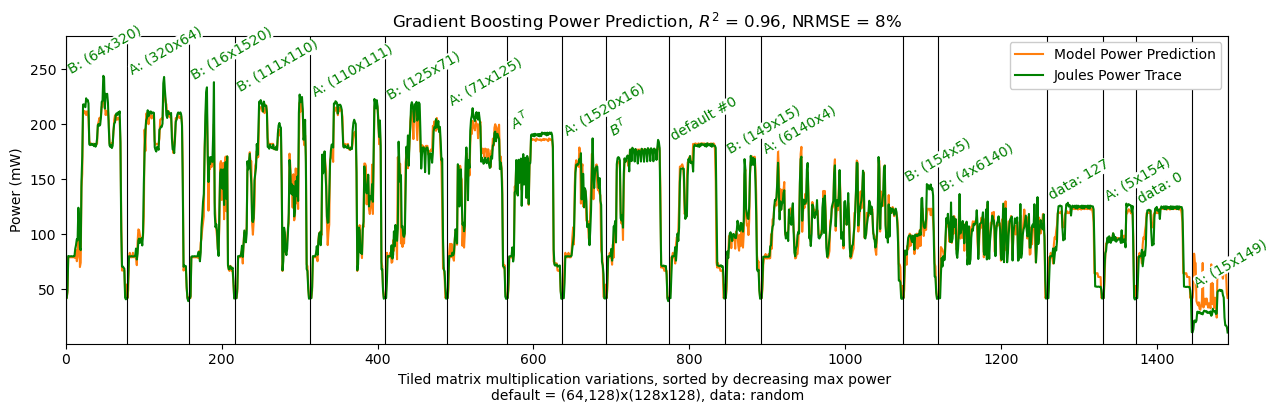

In [22]:
exec(open(f"{scripts_dir}/util.py").read())


plot_power(jpower, y_pred, wb, fig=plt.figure(figsize=(15,4)), y_first=True, y_mult=1.15,title='Gradient Boosting Power Prediction')

plt.legend(loc="upper right",framealpha=1)
plot_gemmini_adjustments()



## 1. Measure population
* sim-opm
* model(proxy toggles)
* Fitness function: Max_Power = Model(proxy toggles)

In [ ]:
print_sim_opm_commands(my_workloads,my_rtl,overwrite=overwrite)

### Genetic Alg

In [23]:
'''
create a new generation of gemmini workload configs
for each workload config:
    generate C code
    run RTL OPM sim
    apply GB model --> power pred
use power pred to select next generation of configs


eventually:
    for some configs (randomly or purposefully selected), re-run entire power flow, retrain model, then continue iteration
    maybe have some toggle anomaly detection to determine if new behavior was observed in generated workloads
'''

'\ncreate a new generation of gemmini workload configs\nfor each workload config:\n    generate C code\n    run RTL OPM sim\n    apply GB model --> power pred\nuse power pred to select next generation of configs\n\n\neventually:\n    for some configs (randomly or purposefully selected), re-run entire power flow, retrain model, then continue iteration\n    maybe have some toggle anomaly detection to determine if new behavior was observed in generated workloads\n'

In [24]:
population = my_workloads
for w in population:
    y_pred = gbr_ls.predict(w_data_dict[w]['ptoggles'])
    w_data_dict[w]['max_power'] = max(y_pred)